# **1. Install and Import the Required Libraries**

In [1]:
# Install all the required libraries
!pip install -U -q pdfplumber tiktoken openai chromaDB sentence-transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.2/48.2 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 3.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.2/60.2 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 57.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 39.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 599.1/599.1 kB 29.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.1/611.1 kB 26.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 55.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 340.6/340.6 kB 19.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.2/284.2 kB 17.8 MB/s eta 

In [2]:
# Import all the required Libraries

import pdfplumber
from pathlib import Path
import pandas as pd
from operator import itemgetter
import json
import tiktoken
import openai
import chromadb
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## **2. Read, Process, and Chunk the PDF Files**
We will be using [pdfplumber](https://https://pypi.org/project/pdfplumber/) to read and process the PDF files.

`pdfplumber` allows for better parsing of the PDF file as it can read various elements of the PDF apart from the plain text, such as, tables, images, etc. It also offers wide functionaties and visual debugging features to help with advanced preprocessing as well.

In [4]:
# Define the path of the PDF
pdf_path = '/content/drive/MyDrive/HelpmateAI/Principal-Sample-Life-Insurance-Policy.pdf'

###**2.1 Reading a single PDF file and exploring it through pdfplumber**

In [5]:
# Open the PDF file
with pdfplumber.open(pdf_path) as pdf:

    # Get one of the pages from the PDF and examine it
    single_page = pdf.pages[6]

    # Extract text from the first page
    text = single_page.extract_text()

    # Extract tables from the first page
    tables = single_page.extract_tables()

    # Print the extracted text
    print(text)

Section A – Eligibility
Member Life Insurance Article 1
Member Accidental Death and Dismemberment Insurance Article 2
Dependent Life Insurance Article 3
Section B - Effective Dates
Member Life Insurance Article 1
Member Accidental Death and Dismemberment Insurance Article 2
Dependent Life Insurance Article 3
Section C - Individual Terminations
Member Life Insurance Article 1
Member Accidental Death and Dismemberment Insurance Article 2
Dependent Life Insurance Article 3
Termination for Fraud Article 4
Coverage While Outside of the United States Article 5
Section D - Continuation
Member Life Insurance Article 1
Dependent Insurance - Developmentally Disabled or
Physically Handicapped Children Article 2
Section E - Reinstatement
Reinstatement Article 1
Federal Required Family and Medical Leave Act (FMLA) Article 2
Reinstatement of Coverage for a Member or Dependent When
Coverage Ends due to Living Outside of the United States Article 3
Section F - Individual Purchase Rights
Member Life In

In [6]:
# Function to check whether a word is present in a table or not for segregation of regular text and tables

def check_bboxes(word, table_bbox):
    # Check whether word is inside a table bbox.
    l = word['x0'], word['top'], word['x1'], word['bottom']
    r = table_bbox
    return l[0] > r[0] and l[1] > r[1] and l[2] < r[2] and l[3] < r[3]

In [7]:
# Function to extract text from a PDF file.
# 1. Declare a variable p to store the iteration of the loop that will help us store page numbers alongside the text
# 2. Declare an empty list 'full_text' to store all the text files
# 3. Use pdfplumber to open the pdf pages one by one
# 4. Find the tables and their locations in the page
# 5. Extract the text from the tables in the variable 'tables'
# 6. Extract the regular words by calling the function check_bboxes() and checking whether words are present in the table or not
# 7. Use the cluster_objects utility to cluster non-table and table words together so that they retain the same chronology as in the original PDF
# 8. Declare an empty list 'lines' to store the page text
# 9. If a text element in present in the cluster, append it to 'lines', else if a table element is present, append the table
# 10. Append the page number and all lines to full_text, and increment 'p'
# 11. When the function has iterated over all pages, return the 'full_text' list

def extract_text_from_pdf(pdf_path):
    p = 0
    full_text = []


    with pdfplumber.open(pdf_path) as pdf:
        for page in pdf.pages:
            page_no = f"Page {p+1}"
            text = page.extract_text()

            tables = page.find_tables()
            table_bboxes = [i.bbox for i in tables]
            tables = [{'table': i.extract(), 'top': i.bbox[1]} for i in tables]
            non_table_words = [word for word in page.extract_words() if not any(
                [check_bboxes(word, table_bbox) for table_bbox in table_bboxes])]
            lines = []

            for cluster in pdfplumber.utils.cluster_objects(non_table_words + tables, itemgetter('top'), tolerance=5):

                if 'text' in cluster[0]:
                    try:
                        lines.append(' '.join([i['text'] for i in cluster]))
                    except KeyError:
                        pass

                elif 'table' in cluster[0]:
                    lines.append(json.dumps(cluster[0]['table']))


            full_text.append([page_no, " ".join(lines)])
            p +=1

    return full_text

*Now that we have defined the function for extracting the text and tables from a PDF, let's iterate and call this function for all the PDFs in our drive and store them in a list.*

In [8]:
# Initialize an empty list to store the extracted texts and document names
data = []

# Process the PDF file
print(f"...Processing {pdf_path}")

# Call the function to extract the text from the PDF
extracted_text = extract_text_from_pdf(pdf_path)

# Convert the extracted list to a PDF, and add a column to store document names
extracted_text_df = pd.DataFrame(extracted_text, columns=['Page No.', 'Page_Text'])

# Append the extracted text and document name to the list
data.append(extracted_text_df)

# Print a message to indicate progress
print(f"Finished processing {pdf_path}")

# Print a message to indicate all PDFs have been processed
print("PDF have been processed.")

...Processing /content/drive/MyDrive/HelpmateAI/Principal-Sample-Life-Insurance-Policy.pdf


Finished processing /content/drive/MyDrive/HelpmateAI/Principal-Sample-Life-Insurance-Policy.pdf
PDF have been processed.


In [9]:
data

[   Page No.                                          Page_Text
 0    Page 1  DOROTHEA GLAUSE S655 RHODE ISLAND JOHN DOE 01/...
 1    Page 2                 This page left blank intentionally
 2    Page 3  POLICY RIDER GROUP INSURANCE POLICY NO: S655 C...
 3    Page 4                 This page left blank intentionally
 4    Page 5  PRINCIPAL LIFE INSURANCE COMPANY (called The P...
 ..      ...                                                ...
 59  Page 60  I f a Dependent who was insured dies during th...
 60  Page 61  Section D - Claim Procedures Article 1 - Notic...
 61  Page 62  A claimant may request an appeal of a claim de...
 62  Page 63                 This page left blank intentionally
 63  Page 64  Principal Life Insurance Company Des Moines, I...
 
 [64 rows x 2 columns]]

In [10]:
# Concatenate all the DFs in the list 'data' together

insurance_pdfs_data = pd.concat(data, ignore_index=True)
# print Page No. and Page_Text from the dataframe
insurance_pdfs_data.shape

(64, 2)

In [11]:
insurance_pdfs_data

,Page No.,Page_Text
0,Page 1,DOROTHEA GLAUSE S655 RHODE ISLAND JOHN DOE 01/...
1,Page 2,This page left blank intentionally
2,Page 3,POLICY RIDER GROUP INSURANCE POLICY NO: S655 C...
3,Page 4,This page left blank intentionally
4,Page 5,PRINCIPAL LIFE INSURANCE COMPANY (called The P...
...,...,...
59,Page 60,I f a Dependent who was insured dies during th...
60,Page 61,Section D - Claim Procedures Article 1 - Notic...
61,Page 62,A claimant may request an appeal of a claim de...
62,Page 63,This page left blank intentionally


In [12]:
# Check one of the extracted page texts to ensure that the text has been correctly read
insurance_pdfs_data.Page_Text[2]

'POLICY RIDER GROUP INSURANCE POLICY NO: S655 COVERAGE: Life EMPLOYER: RHODE ISLAND JOHN DOE Effective on the later of the Date of Issue of this Group Policy or March 1, 2005, the following will apply to your Policy: From time to time The Principal may offer or provide certain employer groups who apply for coverage with The Principal a Financial Services Hotline and Grief Support Services or any other value added service for the employees of that employer group. In addition, The Principal may arrange for third party service providers (i.e., optometrists, health clubs), to provide discounted goods and services to those employer groups who apply for coverage with The Principal or who become insureds/enrollees of The Principal. While The Principal has arranged these goods, services and/or third party provider discounts, the third party service providers are liable to the applicants/insureds/enrollees for the provision of such goods and/or services. The Principal is not responsible for the

In [13]:
# Let's also check the length of all the texts as there might be some empty pages or pages with very few words that we can drop
insurance_pdfs_data['Text_Length'] = insurance_pdfs_data['Page_Text'].apply(lambda x: len(x.split(' ')))


In [14]:
insurance_pdfs_data['Text_Length']

,Text_Length
0,30
1,5
2,230
3,5
4,110
...,...
59,285
60,418
61,322
62,5


In [15]:
insurance_pdfs_data

,Page No.,Page_Text,Text_Length
0,Page 1,DOROTHEA GLAUSE S655 RHODE ISLAND JOHN DOE 01/...,30
1,Page 2,This page left blank intentionally,5
2,Page 3,POLICY RIDER GROUP INSURANCE POLICY NO: S655 C...,230
3,Page 4,This page left blank intentionally,5
4,Page 5,PRINCIPAL LIFE INSURANCE COMPANY (called The P...,110
...,...,...,...
59,Page 60,I f a Dependent who was insured dies during th...,285
60,Page 61,Section D - Claim Procedures Article 1 - Notic...,418
61,Page 62,A claimant may request an appeal of a claim de...,322
62,Page 63,This page left blank intentionally,5


In [16]:
# Store the metadata for each page in a separate column
insurance_pdfs_data['Metadata'] = insurance_pdfs_data.apply(lambda x: { 'Page_No.': x['Page No.']}, axis=1)

In [17]:
insurance_pdfs_data

,Page No.,Page_Text,Text_Length,Metadata
0,Page 1,DOROTHEA GLAUSE S655 RHODE ISLAND JOHN DOE 01/...,30,{'Page_No.': 'Page 1'}
1,Page 2,This page left blank intentionally,5,{'Page_No.': 'Page 2'}
2,Page 3,POLICY RIDER GROUP INSURANCE POLICY NO: S655 C...,230,{'Page_No.': 'Page 3'}
3,Page 4,This page left blank intentionally,5,{'Page_No.': 'Page 4'}
4,Page 5,PRINCIPAL LIFE INSURANCE COMPANY (called The P...,110,{'Page_No.': 'Page 5'}
...,...,...,...,...
59,Page 60,I f a Dependent who was insured dies during th...,285,{'Page_No.': 'Page 60'}
60,Page 61,Section D - Claim Procedures Article 1 - Notic...,418,{'Page_No.': 'Page 61'}
61,Page 62,A claimant may request an appeal of a claim de...,322,{'Page_No.': 'Page 62'}
62,Page 63,This page left blank intentionally,5,{'Page_No.': 'Page 63'}


# **3 Document Chunking**

Before generating embeddings for the extracted text, we need to break the document into smaller, manageable chunks. Since the document contains multiple pages with large amounts of text, chunking ensures that the embeddings remain meaningful and efficient for processing.

We will start with a basic chunking technique, where we divide the text into fixed-size chunks.


**Chunking a single document by fixed size**

In [18]:
#Display the extracted text for all pages in the dataset
insurance_pdfs_data['Page_Text']

,Page_Text
0,DOROTHEA GLAUSE S655 RHODE ISLAND JOHN DOE 01/...
1,This page left blank intentionally
2,POLICY RIDER GROUP INSURANCE POLICY NO: S655 C...
3,This page left blank intentionally
4,PRINCIPAL LIFE INSURANCE COMPANY (called The P...
...,...
59,I f a Dependent who was insured dies during th...
60,Section D - Claim Procedures Article 1 - Notic...
61,A claimant may request an appeal of a claim de...
62,This page left blank intentionally


In [19]:
# Extract the 'Page No.' column to iterate over all pages and prepare the final dataframe with chunks
page_numbers = insurance_pdfs_data["Page No."]

# Display the extracted page numbers
page_numbers

,Page No.
0,Page 1
1,Page 2
2,Page 3
3,Page 4
4,Page 5
...,...
59,Page 60
60,Page 61
61,Page 62
62,Page 63


In [20]:
# Function to split text into fixed-size chunks
def split_text_into_chunks(text, chunk_size):
    chunks = []
    words = text.split()  # Split the text into words

    current_chunk = []  # Store words for the current chunk
    current_chunk_word_count = 0  # Count of words in the current chunk

    for word in words:
        if current_chunk_word_count + len(word) + 1 <= chunk_size:
            current_chunk.append(word)
            current_chunk_word_count += len(word) + 1
        else:
            chunks.append(' '.join(current_chunk))
            current_chunk = [word]
            current_chunk_word_count = len(word)

    if current_chunk:
        chunks.append(' '.join(current_chunk))

    return chunks

In [21]:
def process_page(page_no):
    """
    Processes a single page from the insurance PDF dataset by splitting its text into fixed-size chunks.

    Parameters:
    page_no (int): The page number to process.

    Returns:
    pd.DataFrame: A DataFrame containing chunked text along with page number and metadata.
    """

    # Extract the text for the given page number
    page = insurance_pdfs_data[insurance_pdfs_data['Page No.'] == page_no].Page_Text.values[0]

    # Extract the metadata associated with the given page
    metadata = insurance_pdfs_data[insurance_pdfs_data['Page No.'] == page_no].Metadata.values[0]

    # Check if the extracted text is not empty or None
    if page is not None:
        # Define the fixed chunk size (number of characters per chunk)
        chunk_size = 500

        # Split the text into chunks of the defined size
        text_chunks = split_text_into_chunks(page, chunk_size)

        # Initialize a dictionary to store chunked data
        data = {'Title': [], 'Chunk Text': [], 'Metadata': []}

        # Iterate through the generated text chunks and store them in the dictionary
        for index, chunk in enumerate(text_chunks):
            data['Title'].append(page_no)  # Store the page number as the title
            data['Chunk Text'].append(chunk)  # Store the chunked text

            # Add chunk number to metadata to track its position in the original page
            metadata['Chunk_No.'] = index
            data['Metadata'].append(metadata)

        # Convert the dictionary to a DataFrame and return it
        return pd.DataFrame(data)


In [22]:
# Initialize an empty list to store processed DataFrames
all_dfs = []

# Iterate over each page number and process it
for page_no in page_numbers:
    df = process_page(page_no)  # Process the page and retrieve the chunked DataFrame
    if df is not None:
        all_dfs.append(df)  # Append the processed DataFrame to the list

# Concatenate all processed DataFrames into a single DataFrame
fixed_chunk_df = pd.concat(all_dfs, ignore_index=True)

# Display the final chunked DataFrame
fixed_chunk_df

,Title,Chunk Text,Metadata
0,Page 1,DOROTHEA GLAUSE S655 RHODE ISLAND JOHN DOE 01/...,"{'Page_No.': 'Page 1', 'Chunk_No.': 0}"
1,Page 2,This page left blank intentionally,"{'Page_No.': 'Page 2', 'Chunk_No.': 0}"
2,Page 3,POLICY RIDER GROUP INSURANCE POLICY NO: S655 C...,"{'Page_No.': 'Page 3', 'Chunk_No.': 2}"
3,Page 3,arrange for third party service providers (i.e...,"{'Page_No.': 'Page 3', 'Chunk_No.': 2}"
4,Page 3,the provision of such goods and/or services no...,"{'Page_No.': 'Page 3', 'Chunk_No.': 2}"
...,...,...,...
226,Page 62,"requested additional information, The Principa...","{'Page_No.': 'Page 62', 'Chunk_No.': 3}"
227,Page 62,may have the Member or Dependent whose loss is...,"{'Page_No.': 'Page 62', 'Chunk_No.': 3}"
228,Page 62,proof of loss has been filed and before the ap...,"{'Page_No.': 'Page 62', 'Chunk_No.': 3}"
229,Page 63,This page left blank intentionally,"{'Page_No.': 'Page 63', 'Chunk_No.': 0}"


## **4. Generate and Store Embeddings using OpenAI and ChromaDB**

In this section, we will embed the pages in the dataframe through OpenAI's `text-embedding-ada-002` model, and store them in a ChromaDB collection.

In [23]:
# Install the sentence transformers library
!pip install -q sentence-transformers


In [24]:
# Set the API key

with open("/content/drive/MyDrive/HelpmateAI/OPENAI_API_KEY.txt", "r") as f:
  openai.api_key = ' '.join(f.readlines())

In [25]:
# Import the OpenAI Embedding Function into chroma

from chromadb.utils.embedding_functions import OpenAIEmbeddingFunction

In [26]:
# Define the path where chroma collections will be stored

chroma_data_path = '/content/drive/MyDrive/HelpmateAI/ChromaDB_Data_2'

In [27]:
import chromadb

In [28]:
# Call PersistentClient()

client = chromadb.PersistentClient(path=chroma_data_path)

In [29]:
# Set up the embedding function using the OpenAI embedding model

model = "text-embedding-ada-002"
embedding_function = OpenAIEmbeddingFunction(api_key=openai.api_key, model_name=model)

In [30]:
from chromadb.utils import embedding_functions

sentence_transformer_ef = embedding_functions.SentenceTransformerEmbeddingFunction(model_name="all-MiniLM-L6-v2")

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [31]:
# Convert the page text and metadata from your dataframe to lists to be able to pass it to chroma

documents_list = fixed_chunk_df["Chunk Text"].tolist()
metadata_list = fixed_chunk_df['Metadata'].tolist()

In [32]:
# Initialise a collection in chroma and pass the embedding_function to it so that it used OpenAI embeddings to embed the documents

insurance_collection = client.get_or_create_collection(name='RAG_on_Insurance', embedding_function=sentence_transformer_ef)

In [33]:
# Add the documents and metadata to the collection alongwith generic integer IDs. You can also feed the metadata information as IDs by combining the policy name and page no.

insurance_collection.add(
    documents= documents_list,
    ids = [str(i) for i in range(0, len(documents_list))],
    metadatas = metadata_list
)

In [34]:
# Let's take a look at the first few entries in the collection

insurance_collection.get(
    ids = ['0','1','2'],
    include = ['embeddings', 'documents', 'metadatas']
)

{'ids': ['0', '1', '2'],
 'embeddings': array([[-2.59219240e-02,  4.77775335e-02,  5.58577031e-02, ...,
         -4.93265949e-02, -5.85114881e-02,  2.35519726e-02],
        [ 2.91189607e-02,  6.05740845e-02,  4.64153104e-02, ...,
          5.95400892e-02, -2.83837151e-02,  5.31935412e-03],
        [-6.45379126e-02,  4.31971923e-02, -8.39303757e-05, ...,
         -3.78734246e-02,  1.79674644e-02, -7.36596435e-03]]),
 'documents': ['DOROTHEA GLAUSE S655 RHODE ISLAND JOHN DOE 01/01/2014 711 HIGH STREET GEORGE RI 02903 GROUP POLICY FOR: RHODE ISLAND JOHN DOE ALL MEMBERS Group Member Life Insurance Print Date: 07/16/2014',
  'This page left blank intentionally',
  'POLICY RIDER GROUP INSURANCE POLICY NO: S655 COVERAGE: Life EMPLOYER: RHODE ISLAND JOHN DOE Effective on the later of the Date of Issue of this Group Policy or March 1, 2005, the following will apply to your Policy: From time to time The Principal may offer or provide certain employer groups who apply for coverage with The Princi

In [35]:
cache_collection = client.get_or_create_collection(name='Insurance_Cache')

In [36]:
cache_collection.peek()

{'ids': [],
 'embeddings': array([], dtype=float64),
 'documents': [],
 'uris': None,
 'data': None,
 'metadatas': [],
 'included': [<IncludeEnum.embeddings: 'embeddings'>,
  <IncludeEnum.documents: 'documents'>,
  <IncludeEnum.metadatas: 'metadatas'>]}

## **5. Semantic Search with Cache**

In this section, we will perform a semantic search of a query in the collections embeddings to get several top semantically similar results.

### **Query 1**

In [37]:
# Read the user query- What documentation is required when filing a claim?

query = input()

What documentation is required when filing a claim?


In [38]:
# Searh the Cache collection first
# Query the collection against the user query and return the top 20 results

cache_results = cache_collection.query(
    query_texts=query,
    n_results=1
)

/root/.cache/chroma/onnx_models/all-MiniLM-L6-v2/onnx.tar.gz: 100%|██████████| 79.3M/79.3M [00:00<00:00, 103MiB/s] 


In [39]:
cache_results

{'ids': [[]],
 'embeddings': None,
 'documents': [[]],
 'uris': None,
 'data': None,
 'metadatas': [[]],
 'distances': [[]],
 'included': [<IncludeEnum.distances: 'distances'>,
  <IncludeEnum.documents: 'documents'>,
  <IncludeEnum.metadatas: 'metadatas'>]}

In [40]:
# get result from main collection
results = insurance_collection.query(
query_texts=query,
n_results=10
)
print("Result size is : " + str(len(results.items())))
results.items()

Result size is : 8


dict_items([('ids', [['121', '222', '221', '193', '220', '226', '224', '227', '89', '15']]), ('embeddings', None), ('documents', [['and with 31-day notice, upon finding in a civil or criminal case that a Member or Dependent has submitted claims that contain false or fraudulent elements under state or federal law; or c. in Writing and with 31-day notice, when a Member or Dependent has submitted a claim which, in good faith judgement and investigation, a Member or Dependent knew or should have known, contains false or fraudulent elements under state or federal law. Article 5 - Coverage While Outside of the United States If a', 'date of the loss. Proof required includes the date, nature, and extent of the loss. The Principal may request additional information to substantiate loss or require a Signed unaltered authorization to obtain that information from the provider. Failure to comply with the request of The Principal could result in declination of the claim. For purposes of satisfying t

In [41]:
# Implementing Cache in Semantic Search
# Set a threshold for cache search
threshold = 0.2

ids = []
documents = []
distances = []
metadatas = []
results_df = pd.DataFrame()


# If the distance is greater than the threshold, then return the results from the main collection.

if cache_results['distances'][0] == [] or cache_results['distances'][0][0] > threshold:
      # Query the collection against the user query and return the top 10 results
      results = insurance_collection.query(
      query_texts=query,
      n_results=10
      )

      # Store the query in cache_collection as document w.r.t to ChromaDB so that it can be embedded and searched against later
      # Store retrieved text, ids, distances and metadatas in cache_collection as metadatas, so that they can be fetched easily if a query indeed matches to a query in cache
      Keys = []
      Values = []

      for key, val in results.items():
        if val is None:
          continue
        for i in range(0,9):
          Keys.append(str(key)+str(i))
          Values.append(str(val[0][i]))


      cache_collection.add(
          documents= [query],
          ids = [query],  # Or if you want to assign integers as IDs 0,1,2,.., then you can use "len(cache_results['documents'])" as will return the no. of queries currently in the cache and assign the next digit to the new query."
          metadatas = dict(zip(Keys, Values))
      )

      print("Not found in cache. Found in main collection.")

      result_dict = {'Metadatas': results['metadatas'][0], 'Documents': results['documents'][0], 'Distances': results['distances'][0], "IDs":results["ids"][0]}
      results_df = pd.DataFrame.from_dict(result_dict)
      results_df


# If the distance is, however, less than the threshold, you can return the results from cache

elif cache_results['distances'][0][0] <= threshold:
      cache_result_dict = cache_results['metadatas'][0][0]

      # Loop through each inner list and then through the dictionary
      for key, value in cache_result_dict.items():
          if 'ids' in key:
              ids.append(value)
          elif 'documents' in key:
              documents.append(value)
          elif 'distances' in key:
              distances.append(value)
          elif 'metadatas' in key:
              metadatas.append(value)

      print("Found in cache!")

      # Create a DataFrame
      results_df = pd.DataFrame({
        'IDs': ids,
        'Documents': documents,
        'Distances': distances,
        'Metadatas': metadatas
      })


Not found in cache. Found in main collection.


In [42]:
results_df

,Metadatas,Documents,Distances,IDs
0,"{'Chunk_No.': 3, 'Page_No.': 'Page 36'}","and with 31-day notice, upon finding in a civi...",1.058486,121
1,"{'Chunk_No.': 4, 'Page_No.': 'Page 61'}",date of the loss. Proof required includes the ...,1.064288,222
2,"{'Chunk_No.': 4, 'Page_No.': 'Page 61'}","of claim, will provide appropriate claim forms...",1.107743,221
3,"{'Chunk_No.': 4, 'Page_No.': 'Page 54'}","f . claim requirements listed in PART IV, Sect...",1.140629,193
4,"{'Chunk_No.': 4, 'Page_No.': 'Page 61'}",Section D - Claim Procedures Article 1 - Notic...,1.152721,220
5,"{'Chunk_No.': 3, 'Page_No.': 'Page 62'}","requested additional information, The Principa...",1.155940,226
6,"{'Chunk_No.': 4, 'Page_No.': 'Page 61'}",incomplete claim. Written notification will be...,1.162974,224
7,"{'Chunk_No.': 3, 'Page_No.': 'Page 62'}",may have the Member or Dependent whose loss is...,1.168447,227
8,"{'Chunk_No.': 4, 'Page_No.': 'Page 29'}",the request is made within 31 days after the d...,1.179964,89
9,"{'Chunk_No.': 2, 'Page_No.': 'Page 8'}",5 Loss of Speech and/or Hearing Benefit Articl...,1.203511,15


### **Query 2**

In [43]:
# Read the user query-
#What is the procedure for claiming benefits under the "Accelerated Benefits" provision, and what conditions qualify for this benefit?

query2 = input()

What is the procedure for claiming benefits under the "Accelerated Benefits" provision, and what conditions qualify for this benefit?


In [44]:
# Searh the Cache collection first
# Query the collection against the user query and return the top 20 results

cache_results2 = cache_collection.query(
    query_texts=query2,
    n_results=1
)

In [45]:
cache_results2

{'ids': [['What documentation is required when filing a claim?']],
 'embeddings': None,
 'documents': [['What documentation is required when filing a claim?']],
 'uris': None,
 'data': None,
 'metadatas': [[{'distances0': '1.058485984802246',
    'distances1': '1.0642883578374387',
    'distances2': '1.1077425763976831',
    'distances3': '1.1406292915344238',
    'distances4': '1.152721285400855',
    'distances5': '1.1559401056928584',
    'distances6': '1.162973964545107',
    'distances7': '1.1684469373788935',
    'distances8': '1.1799635887145996',
    'documents0': 'and with 31-day notice, upon finding in a civil or criminal case that a Member or Dependent has submitted claims that contain false or fraudulent elements under state or federal law; or c. in Writing and with 31-day notice, when a Member or Dependent has submitted a claim which, in good faith judgement and investigation, a Member or Dependent knew or should have known, contains false or fraudulent elements under stat

In [46]:
# Implementing Cache in Semantic Search

# Set a threshold for cache search
threshold = 0.2

ids2 = []
documents2 = []
distances2 = []
metadatas2 = []
results_df2 = pd.DataFrame()


# If the distance is greater than the threshold, then return the results from the main collection.

if cache_results2['distances'][0] == [] or cache_results2['distances'][0][0] > threshold:
      # Query the collection against the user query and return the top 10 results
      results = insurance_collection.query(
      query_texts=query2,
      n_results=10
      )

      # Store the query in cache_collection as document w.r.t to ChromaDB so that it can be embedded and searched against later
      # Store retrieved text, ids, distances and metadatas in cache_collection as metadatas, so that they can be fetched easily if a query indeed matches to a query in cache
      Keys2 = []
      Values2 = []

      for key, val in results.items():
        if val is None:
          continue
        if key != 'embeddings':
          for i in range(0,9): # Top 10 variable, we can also put as 25 for top_n
            Keys2.append(str(key)+str(i))
            Values2.append(str(val[0][i]))


      cache_collection.add(
          documents= [query2],
          ids = [query2],  # Or if you want to assign integers as IDs 0,1,2,.., then you can use "len(cache_results['documents'])" as will return the no. of queries currently in the cache and assign the next digit to the new query."
          metadatas = dict(zip(Keys2, Values2))
      )

      print("Not found in cache. Found in main collection.")

      result_dict2 = {'Metadatas': results['metadatas'][0], 'Documents': results['documents'][0], 'Distances': results['distances'][0], "IDs":results["ids"][0]}
      results_df2 = pd.DataFrame.from_dict(result_dict2)
      results_df2


# If the distance is, however, less than the threshold, you can return the results from cache

elif cache_results2['distances'][0][0] <= threshold:
      cache_result_dict2 = cache_results2['metadatas'][0][0]

      # Loop through each inner list and then through the dictionary
      for key, value in cache_result_dict2.items():
          if 'ids' in key:
              ids2.append(value)
          elif 'documents' in key:
              documents2.append(value)
          elif 'distances' in key:
              distances2.append(value)
          elif 'metadatas' in key:
              metadatas2.append(value)

      print("Found in cache!")

      # Create a DataFrame
      results_df2 = pd.DataFrame({
        'IDs': ids2,
        'Documents': documents2,
        'Distances': distances2,
        'Metadatas': metadatas2
      })



Not found in cache. Found in main collection.


In [47]:
results_df2

,Metadatas,Documents,Distances,IDs
0,"{'Chunk_No.': 3, 'Page_No.': 'Page 14'}",Accelerated Benefits. Total Disability; Totall...,0.552256,41
1,"{'Chunk_No.': 3, 'Page_No.': 'Page 51'}",disability that: (1) results from willful self...,0.552428,183
2,"{'Chunk_No.': 3, 'Page_No.': 'Page 13'}",Principal. This proof must be provided in a fo...,0.673189,36
3,"{'Chunk_No.': 4, 'Page_No.': 'Page 43'}",any Accelerated Benefit payment as described i...,0.752295,147
4,"{'Chunk_No.': 2, 'Page_No.': 'Page 52'}",(1) only one Accelerated Benefit payment will ...,0.760959,186
5,"{'Chunk_No.': 4, 'Page_No.': 'Page 61'}",incomplete claim. Written notification will be...,0.781028,224
6,"{'Chunk_No.': 3, 'Page_No.': 'Page 51'}",Accelerated Benefit payment to The Principal; ...,0.786964,184
7,"{'Chunk_No.': 3, 'Page_No.': 'Page 46'}",PART IV - BENEFITS Section A - Member Life Ins...,0.798068,157
8,"{'Chunk_No.': 4, 'Page_No.': 'Page 28'}","terms of the Prior Policy, to have their premi...",0.912392,85
9,"{'Chunk_No.': 4, 'Page_No.': 'Page 43'}",be the Coverage During Disability benefit in f...,0.935298,146


### **Query 3**

In [48]:
# Read the user query
#What provisions are included under the "Member Life Insurance - Coverage During Disability" section?
query3 = input()

What provisions are included under the "Member Life Insurance - Coverage During Disability" section?


In [49]:
# Searh the Cache collection first
# Query the collection against the user query and return the top 20 results

cache_results3 = cache_collection.query(
    query_texts=query3,
    n_results=1
)

In [50]:

cache_results3

{'ids': [['What is the procedure for claiming benefits under the "Accelerated Benefits" provision, and what conditions qualify for this benefit?']],
 'embeddings': None,
 'documents': [['What is the procedure for claiming benefits under the "Accelerated Benefits" provision, and what conditions qualify for this benefit?']],
 'uris': None,
 'data': None,
 'metadatas': [[{'distances0': '0.5522557497024536',
    'distances1': '0.5524275302886963',
    'distances2': '0.6731890439987183',
    'distances3': '0.7522951364517212',
    'distances4': '0.7609586119651794',
    'distances5': '0.7810279719978673',
    'distances6': '0.7869640588760376',
    'distances7': '0.7980676293373108',
    'distances8': '0.912392258644104',
    'documents0': "Accelerated Benefits. Total Disability; Totally Disabled A Member's inability, as determined by The Principal, due to sickness or injury, to perform the majority of the material duties of any occupation for which he or she is or may reasonably become qua

In [51]:
# Implementing Cache in Semantic Search

# Set a threshold for cache search
threshold = 0.2

ids3 = []
documents3 = []
distances3 = []
metadatas3 = []
results_df3 = pd.DataFrame()


# If the distance is greater than the threshold, then return the results from the main collection.

if cache_results3['distances'][0] == [] or cache_results3['distances'][0][0] > threshold:
      # Query the collection against the user query and return the top 10 results
      results = insurance_collection.query(
      query_texts=query3,
      n_results=10
      )

      # Store the query in cache_collection as document w.r.t to ChromaDB so that it can be embedded and searched against later
      # Store retrieved text, ids, distances and metadatas in cache_collection as metadatas, so that they can be fetched easily if a query indeed matches to a query in cache
      Keys3 = []
      Values3 = []

      for key, val in results.items():
        if val is None:
          continue
        if key != 'embeddings':
          for i in range(0,9): # Top 10 variable, we can also put as 25 for top_n
            Keys3.append(str(key)+str(i))
            Values3.append(str(val[0][i]))


      cache_collection.add(
          documents= [query3],
          ids = [query3],  # Or if you want to assign integers as IDs 0,1,2,.., then you can use "len(cache_results['documents'])" as will return the no. of queries currently in the cache and assign the next digit to the new query."
          metadatas = dict(zip(Keys3, Values3))
      )

      print("Not found in cache. Found in main collection.")

      result_dict3 = {'Metadatas': results['metadatas'][0], 'Documents': results['documents'][0], 'Distances': results['distances'][0], "IDs":results["ids"][0]}
      results_df3 = pd.DataFrame.from_dict(result_dict3)
      results_df3


# If the distance is, however, less than the threshold, you can return the results from cache

elif cache_results3['distances'][0][0] <= threshold:
      cache_result_dict3 = cache_results3['metadatas'][0][0]

      # Loop through each inner list and then through the dictionary
      for key, value in cache_result_dict3.items():
          if 'ids' in key:
              ids3.append(value)
          elif 'documents' in key:
              documents3.append(value)
          elif 'distances' in key:
              distances3.append(value)
          elif 'metadatas' in key:
              metadatas3.append(value)

      print("Found in cache!")

      # Create a DataFrame
      results_df3 = pd.DataFrame({
        'IDs': ids3,
        'Documents': documents3,
        'Distances': distances3,
        'Metadatas': metadatas3
      })

Not found in cache. Found in main collection.


In [52]:
results_df3

,Metadatas,Documents,Distances,IDs
0,"{'Chunk_No.': 4, 'Page_No.': 'Page 42'}",Member Life Insurance or Coverage During Disab...,0.532828,143
1,"{'Chunk_No.': 4, 'Page_No.': 'Page 49'}",Payment of benefits will be subject to the Ben...,0.539540,171
2,"{'Chunk_No.': 4, 'Page_No.': 'Page 42'}",class eligible for insurance; or (2) after the...,0.617669,141
3,"{'Chunk_No.': 4, 'Page_No.': 'Page 43'}",be the Coverage During Disability benefit in f...,0.618830,146
4,"{'Chunk_No.': 2, 'Page_No.': 'Page 8'}",Section A - Member Life Insurance Schedule of ...,0.629080,14
5,"{'Chunk_No.': 4, 'Page_No.': 'Page 42'}","Premium Waiver Period as described in PART IV,...",0.682335,142
6,"{'Chunk_No.': 4, 'Page_No.': 'Page 28'}","terms of the Prior Policy, to have their premi...",0.691066,85
7,"{'Chunk_No.': 2, 'Page_No.': 'Page 26'}",PART III - INDIVIDUAL REQUIREMENTS AND RIGHTS ...,0.712731,77
8,"{'Chunk_No.': 4, 'Page_No.': 'Page 44'}",Dependent's Life Insurance terminates because ...,0.715262,151
9,"{'Chunk_No.': 2, 'Page_No.': 'Page 7'}",Article 4 Coverage While Outside of the United...,0.730468,12


## **6.Re-Ranking with a Cross Encoder**

Re-ranking the results obtained from your semantic search can sometime significantly improve the relevance of the retrieved results. This is often done by passing the query paired with each of the retrieved responses into a cross-encoder to score the relevance of the response w.r.t. the query.

<br>

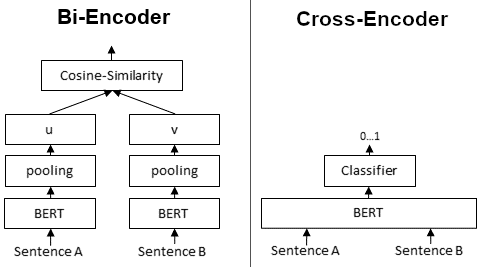

<br>

In [53]:
# Import the CrossEncoder library from sentence_transformers

from sentence_transformers import CrossEncoder, util

In [54]:
# Initialise the cross encoder model

cross_encoder = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2')

config.json:   0%|          | 0.00/794 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.66k [00:00<?, ?B/s]

In [55]:
# Test the cross encoder model

scores = cross_encoder.predict([['Does the insurance cover diabetic patients?', 'The insurance policy covers some pre-existing conditions including diabetes, heart diseases, etc. The policy does not howev'],
                                ['Does the insurance cover diabetic patients?', 'The premium rates for various age groups are given as follows. Age group (<18 years): Premium rate']])

In [56]:
scores

array([  3.8467617, -11.252879 ], dtype=float32)

**Query 1:**

In [57]:
# Input (query, response) pairs for each of the top 20 responses received from the semantic search to the cross encoder
# Generate the cross_encoder scores for these pairs
cross_inputs = [[query, response] for response in results_df['Documents']]
cross_rerank_scores = cross_encoder.predict(cross_inputs)

In [58]:
cross_rerank_scores

array([-4.465494 ,  1.0554475,  1.258501 , -3.5270972, -1.7595427,
       -2.031552 , -3.300685 , -3.9635181, -7.176235 , -8.708506 ],
      dtype=float32)

In [59]:
# Store the rerank_scores in results_df

results_df['Reranked_scores'] = cross_rerank_scores

In [60]:
results_df

,Metadatas,Documents,Distances,IDs,Reranked_scores
0,"{'Chunk_No.': 3, 'Page_No.': 'Page 36'}","and with 31-day notice, upon finding in a civi...",1.058486,121,-4.465494
1,"{'Chunk_No.': 4, 'Page_No.': 'Page 61'}",date of the loss. Proof required includes the ...,1.064288,222,1.055447
2,"{'Chunk_No.': 4, 'Page_No.': 'Page 61'}","of claim, will provide appropriate claim forms...",1.107743,221,1.258501
3,"{'Chunk_No.': 4, 'Page_No.': 'Page 54'}","f . claim requirements listed in PART IV, Sect...",1.140629,193,-3.527097
4,"{'Chunk_No.': 4, 'Page_No.': 'Page 61'}",Section D - Claim Procedures Article 1 - Notic...,1.152721,220,-1.759543
5,"{'Chunk_No.': 3, 'Page_No.': 'Page 62'}","requested additional information, The Principa...",1.155940,226,-2.031552
6,"{'Chunk_No.': 4, 'Page_No.': 'Page 61'}",incomplete claim. Written notification will be...,1.162974,224,-3.300685
7,"{'Chunk_No.': 3, 'Page_No.': 'Page 62'}",may have the Member or Dependent whose loss is...,1.168447,227,-3.963518
8,"{'Chunk_No.': 4, 'Page_No.': 'Page 29'}",the request is made within 31 days after the d...,1.179964,89,-7.176235
9,"{'Chunk_No.': 2, 'Page_No.': 'Page 8'}",5 Loss of Speech and/or Hearing Benefit Articl...,1.203511,15,-8.708506


In [61]:
# Return the top 3 results from semantic search

top_3_semantic = results_df.sort_values(by='Distances')
top_3_semantic[:3]

,Metadatas,Documents,Distances,IDs,Reranked_scores
0,"{'Chunk_No.': 3, 'Page_No.': 'Page 36'}","and with 31-day notice, upon finding in a civi...",1.058486,121,-4.465494
1,"{'Chunk_No.': 4, 'Page_No.': 'Page 61'}",date of the loss. Proof required includes the ...,1.064288,222,1.055447
2,"{'Chunk_No.': 4, 'Page_No.': 'Page 61'}","of claim, will provide appropriate claim forms...",1.107743,221,1.258501


In [62]:
# Return the top 3 results after reranking

top_3_rerank = results_df.sort_values(by='Reranked_scores', ascending=False)
top_3_rerank[:3]

,Metadatas,Documents,Distances,IDs,Reranked_scores
2,"{'Chunk_No.': 4, 'Page_No.': 'Page 61'}","of claim, will provide appropriate claim forms...",1.107743,221,1.258501
1,"{'Chunk_No.': 4, 'Page_No.': 'Page 61'}",date of the loss. Proof required includes the ...,1.064288,222,1.055447
4,"{'Chunk_No.': 4, 'Page_No.': 'Page 61'}",Section D - Claim Procedures Article 1 - Notic...,1.152721,220,-1.759543


In [63]:
top_3_RAG_q1 = top_3_rerank[["Documents", "Metadatas"]][:3]

In [64]:
top_3_RAG_q1

,Documents,Metadatas
2,"of claim, will provide appropriate claim forms...","{'Chunk_No.': 4, 'Page_No.': 'Page 61'}"
1,date of the loss. Proof required includes the ...,"{'Chunk_No.': 4, 'Page_No.': 'Page 61'}"
4,Section D - Claim Procedures Article 1 - Notic...,"{'Chunk_No.': 4, 'Page_No.': 'Page 61'}"


**Query 2:**

In [65]:
results_df2.head()

,Metadatas,Documents,Distances,IDs
0,"{'Chunk_No.': 3, 'Page_No.': 'Page 14'}",Accelerated Benefits. Total Disability; Totall...,0.552256,41
1,"{'Chunk_No.': 3, 'Page_No.': 'Page 51'}",disability that: (1) results from willful self...,0.552428,183
2,"{'Chunk_No.': 3, 'Page_No.': 'Page 13'}",Principal. This proof must be provided in a fo...,0.673189,36
3,"{'Chunk_No.': 4, 'Page_No.': 'Page 43'}",any Accelerated Benefit payment as described i...,0.752295,147
4,"{'Chunk_No.': 2, 'Page_No.': 'Page 52'}",(1) only one Accelerated Benefit payment will ...,0.760959,186


In [66]:
query2

'What is the procedure for claiming benefits under the "Accelerated Benefits" provision, and what conditions qualify for this benefit?'

In [67]:
cross_inputs2 = [[query2, response] for response in results_df2['Documents']]
cross_rerank_scores2 = cross_encoder.predict(cross_inputs2)
cross_rerank_scores2

array([-0.05604591,  1.301053  ,  4.825674  , -0.2815024 , -1.6938887 ,
       -0.7162808 , -1.0776806 ,  0.5492911 , -6.53306   , -3.19806   ],
      dtype=float32)

In [68]:
# Store the rerank_scores in results_df
results_df2['Reranked_scores'] = cross_rerank_scores2
results_df2

,Metadatas,Documents,Distances,IDs,Reranked_scores
0,"{'Chunk_No.': 3, 'Page_No.': 'Page 14'}",Accelerated Benefits. Total Disability; Totall...,0.552256,41,-0.056046
1,"{'Chunk_No.': 3, 'Page_No.': 'Page 51'}",disability that: (1) results from willful self...,0.552428,183,1.301053
2,"{'Chunk_No.': 3, 'Page_No.': 'Page 13'}",Principal. This proof must be provided in a fo...,0.673189,36,4.825674
3,"{'Chunk_No.': 4, 'Page_No.': 'Page 43'}",any Accelerated Benefit payment as described i...,0.752295,147,-0.281502
4,"{'Chunk_No.': 2, 'Page_No.': 'Page 52'}",(1) only one Accelerated Benefit payment will ...,0.760959,186,-1.693889
5,"{'Chunk_No.': 4, 'Page_No.': 'Page 61'}",incomplete claim. Written notification will be...,0.781028,224,-0.716281
6,"{'Chunk_No.': 3, 'Page_No.': 'Page 51'}",Accelerated Benefit payment to The Principal; ...,0.786964,184,-1.077681
7,"{'Chunk_No.': 3, 'Page_No.': 'Page 46'}",PART IV - BENEFITS Section A - Member Life Ins...,0.798068,157,0.549291
8,"{'Chunk_No.': 4, 'Page_No.': 'Page 28'}","terms of the Prior Policy, to have their premi...",0.912392,85,-6.533060
9,"{'Chunk_No.': 4, 'Page_No.': 'Page 43'}",be the Coverage During Disability benefit in f...,0.935298,146,-3.198060


In [69]:
# Return the top 3 results from semantic search

top_3_semantic2_q2 = results_df2.sort_values(by='Distances')
top_3_semantic2_q2[:3]

,Metadatas,Documents,Distances,IDs,Reranked_scores
0,"{'Chunk_No.': 3, 'Page_No.': 'Page 14'}",Accelerated Benefits. Total Disability; Totall...,0.552256,41,-0.056046
1,"{'Chunk_No.': 3, 'Page_No.': 'Page 51'}",disability that: (1) results from willful self...,0.552428,183,1.301053
2,"{'Chunk_No.': 3, 'Page_No.': 'Page 13'}",Principal. This proof must be provided in a fo...,0.673189,36,4.825674


In [70]:
# Return the top 3 results after reranking

top_3_rerank_q2 = results_df2.sort_values(by='Reranked_scores', ascending=False)
top_3_rerank_q2[:3]

,Metadatas,Documents,Distances,IDs,Reranked_scores
2,"{'Chunk_No.': 3, 'Page_No.': 'Page 13'}",Principal. This proof must be provided in a fo...,0.673189,36,4.825674
1,"{'Chunk_No.': 3, 'Page_No.': 'Page 51'}",disability that: (1) results from willful self...,0.552428,183,1.301053
7,"{'Chunk_No.': 3, 'Page_No.': 'Page 46'}",PART IV - BENEFITS Section A - Member Life Ins...,0.798068,157,0.549291


In [71]:
top_3_RAG_q2 = top_3_rerank_q2[["Documents", "Metadatas"]][:3]
top_3_RAG_q2

,Documents,Metadatas
2,Principal. This proof must be provided in a fo...,"{'Chunk_No.': 3, 'Page_No.': 'Page 13'}"
1,disability that: (1) results from willful self...,"{'Chunk_No.': 3, 'Page_No.': 'Page 51'}"
7,PART IV - BENEFITS Section A - Member Life Ins...,"{'Chunk_No.': 3, 'Page_No.': 'Page 46'}"


**Query 3**

In [72]:
query3

'What provisions are included under the "Member Life Insurance - Coverage During Disability" section?'

In [73]:
results_df3.head()

,Metadatas,Documents,Distances,IDs
0,"{'Chunk_No.': 4, 'Page_No.': 'Page 42'}",Member Life Insurance or Coverage During Disab...,0.532828,143
1,"{'Chunk_No.': 4, 'Page_No.': 'Page 49'}",Payment of benefits will be subject to the Ben...,0.539540,171
2,"{'Chunk_No.': 4, 'Page_No.': 'Page 42'}",class eligible for insurance; or (2) after the...,0.617669,141
3,"{'Chunk_No.': 4, 'Page_No.': 'Page 43'}",be the Coverage During Disability benefit in f...,0.618830,146
4,"{'Chunk_No.': 2, 'Page_No.': 'Page 8'}",Section A - Member Life Insurance Schedule of ...,0.629080,14


In [74]:
# Input (query, response) pairs for each of the top 20 responses received from the semantic search to the cross encoder
# Generate the cross_encoder scores for these pairs
cross_inputs3 = [[query3, response] for response in results_df3['Documents']]
cross_rerank_scores3 = cross_encoder.predict(cross_inputs3)
cross_rerank_scores3

array([ 5.689448 ,  8.085384 ,  4.8766603,  3.9774091,  5.5096507,
        3.1614044, -2.6808882,  2.144577 ,  4.7932043,  4.3719964],
      dtype=float32)

In [75]:
# Store the rerank_scores in results_df

results_df3['Reranked_scores'] = cross_rerank_scores3
results_df3

,Metadatas,Documents,Distances,IDs,Reranked_scores
0,"{'Chunk_No.': 4, 'Page_No.': 'Page 42'}",Member Life Insurance or Coverage During Disab...,0.532828,143,5.689448
1,"{'Chunk_No.': 4, 'Page_No.': 'Page 49'}",Payment of benefits will be subject to the Ben...,0.539540,171,8.085384
2,"{'Chunk_No.': 4, 'Page_No.': 'Page 42'}",class eligible for insurance; or (2) after the...,0.617669,141,4.876660
3,"{'Chunk_No.': 4, 'Page_No.': 'Page 43'}",be the Coverage During Disability benefit in f...,0.618830,146,3.977409
4,"{'Chunk_No.': 2, 'Page_No.': 'Page 8'}",Section A - Member Life Insurance Schedule of ...,0.629080,14,5.509651
5,"{'Chunk_No.': 4, 'Page_No.': 'Page 42'}","Premium Waiver Period as described in PART IV,...",0.682335,142,3.161404
6,"{'Chunk_No.': 4, 'Page_No.': 'Page 28'}","terms of the Prior Policy, to have their premi...",0.691066,85,-2.680888
7,"{'Chunk_No.': 2, 'Page_No.': 'Page 26'}",PART III - INDIVIDUAL REQUIREMENTS AND RIGHTS ...,0.712731,77,2.144577
8,"{'Chunk_No.': 4, 'Page_No.': 'Page 44'}",Dependent's Life Insurance terminates because ...,0.715262,151,4.793204
9,"{'Chunk_No.': 2, 'Page_No.': 'Page 7'}",Article 4 Coverage While Outside of the United...,0.730468,12,4.371996


In [76]:
# Return the top 3 results from semantic search

top_3_semantic_q3 = results_df3.sort_values(by='Distances')
top_3_semantic_q3[:3]

,Metadatas,Documents,Distances,IDs,Reranked_scores
0,"{'Chunk_No.': 4, 'Page_No.': 'Page 42'}",Member Life Insurance or Coverage During Disab...,0.532828,143,5.689448
1,"{'Chunk_No.': 4, 'Page_No.': 'Page 49'}",Payment of benefits will be subject to the Ben...,0.539540,171,8.085384
2,"{'Chunk_No.': 4, 'Page_No.': 'Page 42'}",class eligible for insurance; or (2) after the...,0.617669,141,4.876660


In [77]:
# Return the top 3 results after reranking

top_3_rerank_q3 = results_df3.sort_values(by='Reranked_scores', ascending=False)
top_3_rerank_q3[:3]

,Metadatas,Documents,Distances,IDs,Reranked_scores
1,"{'Chunk_No.': 4, 'Page_No.': 'Page 49'}",Payment of benefits will be subject to the Ben...,0.539540,171,8.085384
0,"{'Chunk_No.': 4, 'Page_No.': 'Page 42'}",Member Life Insurance or Coverage During Disab...,0.532828,143,5.689448
4,"{'Chunk_No.': 2, 'Page_No.': 'Page 8'}",Section A - Member Life Insurance Schedule of ...,0.629080,14,5.509651


In [78]:
top_3_RAG_q3 = top_3_rerank_q3[["Documents", "Metadatas"]][:3]
top_3_RAG_q3

,Documents,Metadatas
1,Payment of benefits will be subject to the Ben...,"{'Chunk_No.': 4, 'Page_No.': 'Page 49'}"
0,Member Life Insurance or Coverage During Disab...,"{'Chunk_No.': 4, 'Page_No.': 'Page 42'}"
4,Section A - Member Life Insurance Schedule of ...,"{'Chunk_No.': 2, 'Page_No.': 'Page 8'}"


## **7. Retrieval Augmented Generation**

Now that we have the final top search results, we can pass it to an GPT 3.5 along with the user query and a well-engineered prompt, to generate a direct answer to the query along with citations, rather than returning whole pages/chunks.

In [79]:
# Define the function to generate the response. Provide a comprehensive prompt that passes the user query and the top 3 results to the model

def generate_response(query, top_3_RAG):
    """
    Generate a response using GPT-3.5's ChatCompletion based on the user query and retrieved information.
    """
    messages = [
                {"role": "system", "content":  "You are a helpful assistant in the insurance domain who can effectively answer user queries about insurance policies and documents."},
                {"role": "user", "content": f"""You are a helpful assistant in the insurance domain who can effectively answer user queries about insurance policies and documents.
                                                You have a question asked by the user in '{query}' and you have some search results from a corpus of insurance documents in the dataframe '{top_3_RAG}'. These search results are essentially one page of an insurance document that may be relevant to the user query.

                                                The column 'documents' inside this dataframe contains the actual text from the policy document and the column 'metadata' contains the policy name and source page. The text inside the document may also contain tables in the format of a list of lists where each of the nested lists indicates a row.

                                                Use the documents in '{top_3_RAG}' to answer the query '{query}'. Frame an informative answer and also, use the dataframe to return the relevant policy names and page numbers as citations.

                                                Follow the guidelines below when performing the task.
                                                1. Try to provide relevant/accurate numbers if available.
                                                2. You don’t have to necessarily use all the information in the dataframe. Only choose information that is relevant.
                                                3. If the document text has tables with relevant information, please reformat the table and return the final information in a tabular in format.
                                                3. Use the Metadatas columns in the dataframe to retrieve and cite the policy name(s) and page numbers(s) as citation.
                                                4. If you can't provide the complete answer, please also provide any information that will help the user to search specific sections in the relevant cited documents.
                                                5. You are a customer facing assistant, so do not provide any information on internal workings, just answer the query directly.

                                                The generated response should answer the query directly addressing the user and avoiding additional information. If you think that the query is not relevant to the document, reply that the query is irrelevant. Provide the final response as a well-formatted and easily readable text along with the citation. Provide your complete response first with all information, and then provide the citations.
                                                """},
              ]

    response = openai.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=messages
    )

    return response.choices[0].message.content.split('\n')

In [80]:
query

'What documentation is required when filing a claim?'

In [81]:
# Generate the response - For Query 1
response = generate_response(query, top_3_RAG_q1)
print("Query 1: ","\n",query,"\n_________________________________________________________________________________________________________________\n_________________________________________________________________________________________________________________\n")
# Print the response
print("\n".join(response))

Query 1:  
 What documentation is required when filing a claim? 
_________________________________________________________________________________________________________________
_________________________________________________________________________________________________________________

When filing a claim, the documentation typically required includes:
1. Claim forms filled out accurately and completely.
2. Proof of the date of loss.
3. Relevant supporting documents, such as receipts, invoices, or other evidence related to the claim.

Here is the information extracted from the policy document for reference:

| Documentation Required                                |                                                                                                      |
|-------------------------------------------------------|------------------------------------------------------------------------------------------------------|
| Claim Forms                                          

In [82]:
query2

'What is the procedure for claiming benefits under the "Accelerated Benefits" provision, and what conditions qualify for this benefit?'

In [88]:
# Generate the response - For Query 2
response2 = generate_response(query2, top_3_RAG_q2)
print("Query 2: ","\n",query2,"\n_________________________________________________________________________________________________________________\n_________________________________________________________________________________________________________________\n")
# Print the response
print("\n".join(response2))

Query 2:  
 What is the procedure for claiming benefits under the "Accelerated Benefits" provision, and what conditions qualify for this benefit? 
_________________________________________________________________________________________________________________
_________________________________________________________________________________________________________________

To claim benefits under the "Accelerated Benefits" provision, the procedure typically involves the following steps:

1. Contact your insurance provider: Notify your insurance provider about your intention to claim accelerated benefits under your policy.

2. Submit required documentation: Provide the necessary documents, which may include medical records, a physician's statement, and any other relevant paperwork to support your claim.

3. Await evaluation: Your claim will be evaluated by the insurance company to determine eligibility for accelerated benefits.

4. Receive benefits: If your claim is approved, you will s

In [86]:
query3

'What provisions are included under the "Member Life Insurance - Coverage During Disability" section?'

In [87]:
# Generate the response - For Query 3

response3 = generate_response(query3, top_3_RAG_q3)
print("Query 3: ","\n",query3,"\n_________________________________________________________________________________________________________________\n_________________________________________________________________________________________________________________\n")
# Print the response
print("\n".join(response3))

Query 3:  
 What provisions are included under the "Member Life Insurance - Coverage During Disability" section? 
_________________________________________________________________________________________________________________
_________________________________________________________________________________________________________________

The "Member Life Insurance - Coverage During Disability" section includes provisions related to the payment of benefits subject to the Benefit Payment Provision. Specific details about the coverage, eligibility criteria, benefit amounts, and any limitations during disability are outlined in this section.

Here is a simplified summary in a tabular format:

| Provision                 | Details                                        |
|---------------------------|------------------------------------------------|
| Payment of Benefits       | Subject to Benefit Payment Provision           |
| Coverage Details          | Eligibility criteria, benefit am